# RSA Searchlight Significance Testing
Use the ltools package to conduct significance tests on the searchlight RSA results

In [1]:
import os
import glob
import pandas as pd

from nltools.stats import zscore, regress, find_spikes
from nltools.data import Brain_Data, Design_Matrix
from nilearn.plotting import view_img, glass_brain, plot_stat_map

import matplotlib.pyplot as plt

### Set paths and set subjects

In [4]:
bids_dir = '/data/projects/social_doors/'


os.chdir(bids_dir)

data_dir = os.path.join(bids_dir, 'derivatives','rsa_searchlight')

# Define subject list
subjs_scan_info = pd.read_csv(bids_dir+'/derivatives/participants_good.tsv', sep='\t')
subjs_scan_info_kids = subjs_scan_info[subjs_scan_info['group'] == 'kid']
subjs_scan_info_colg = subjs_scan_info[subjs_scan_info['group'] == 'college']

subjs_list_kids = list(subjs_scan_info_kids['participant_id'].unique())
subjs_list_kids.sort()
subjs_list_colg = list(subjs_scan_info_colg['participant_id'].unique())
subjs_list_colg.sort()

print('Found '+str(len(subjs_list_kids))+' kid subjects')
print('Found '+str(len(subjs_list_colg))+' college subjects')


Found 32 kid subjects
Found 31 college subjects


In [5]:
file_list = glob.glob(os.path.join(data_dir, 'sub-*_sl_*.nii.gz'))
file_list.sort()


file_list_kids = []
for subj in subjs_list_kids:
    temp_subj_file = [x for x in file_list if subj+'_sl' in x]
    file_list_kids = file_list_kids + temp_subj_file

print('Found '+str(len(file_list_kids))+' kid subject maps')


file_list_colg = []
for subj in subjs_list_colg:
    temp_subj_file = [x for x in file_list if subj+'_sl' in x]
    file_list_colg = file_list_colg+ temp_subj_file

print('Found '+str(len(file_list_colg))+' college subject maps')


Found 192 kid subject maps
Found 177 college subject maps


# Group Analysis
Perform a one sample t-test and multiple comparisons correction

In [6]:
# Define mask
#subj_mni_mask = bids_dir+"derivatives/reliability_analysis/relscenarios/Anatomy/sub-301_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz"

# Define dictionary to store stats
rdm_stats_all = {}

rdm_names = ['valence', 'correct', 'crctval']

for group in ['kid', 'college']:
    if group == 'kid':
        temp_file_list = file_list_kids
        temp_subj_list = subjs_list_kids
    elif group == 'college':
        temp_file_list = file_list_colg
        temp_subj_list = subjs_list_colg
        
        
    for task in ['mdoors','social']:
        for i_rdm in rdm_names:
            # Find subject tmaps for a given component
            rdm_file_list = [x for x in temp_file_list if task+'_'+i_rdm in x]
            rdm_file_list.sort()

            # Load data
            temp_sl_rdm = Brain_Data(rdm_file_list)

            # Perform FDR multiple comparisons correction
            analysis_prefix = group+'_'+task+'_'+i_rdm
            
            rdm_stats_all[analysis_prefix] = temp_sl_rdm.ttest(threshold_dict={'fdr':.05})

            # Export as nifti
            rdm_stats_all[analysis_prefix]['t'].write(os.path.join(data_dir,'tmap_sl_'+analysis_prefix+'_unc.nii.gz'))
            rdm_stats_all[analysis_prefix]['thr_t'].write(os.path.join(data_dir,'tmap_sl_'+analysis_prefix+'_fdr05.nii.gz'))
            

## Visualization

/opt/anaconda3/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


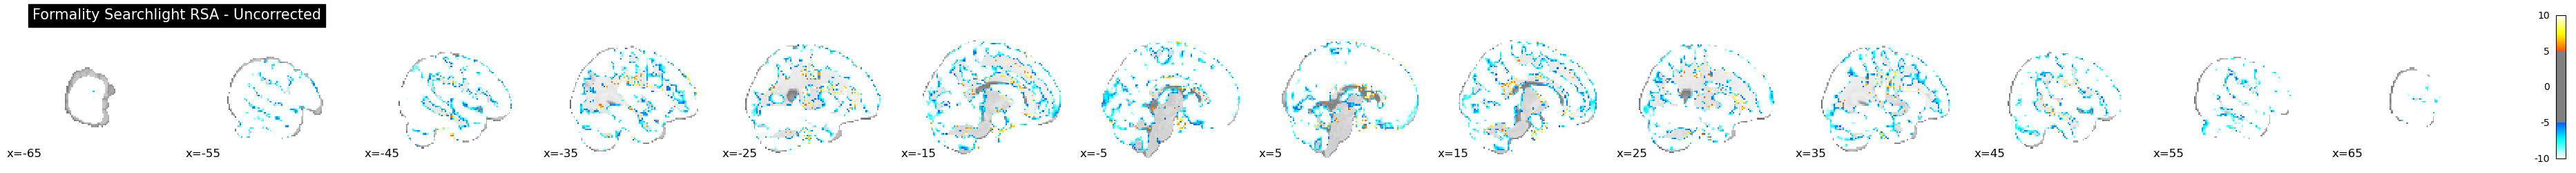

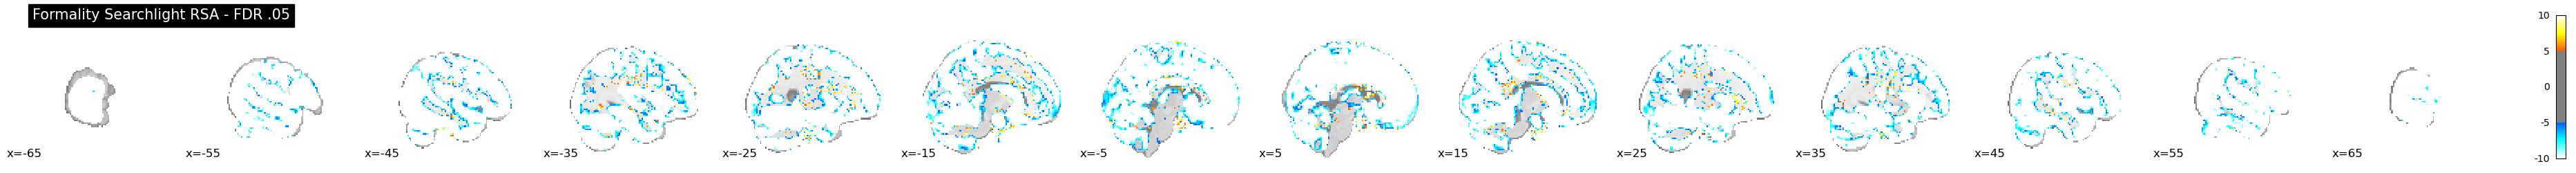

In [7]:
plot_stat_map(rdm_stats_all['college_mdoors_valence']['t'].to_nifti(), threshold=5,
    cut_coords=range(-65, 66, 10), display_mode='x', vmax=10, colorbar=True,
    title='Formality Searchlight RSA - Uncorrected')
#plt.savefig(data_dir+'/tmap_sl_comp1_unc.png')

plot_stat_map(rdm_stats_all['college_mdoors_valence']['thr_t'].to_nifti(), threshold=5,
    cut_coords=range(-65, 66, 10), display_mode='x', vmax=10, colorbar=True,
    title='Formality Searchlight RSA - FDR .05')
#plt.savefig(data_dir+'/tmap_sl_comp1_fdr05.png')

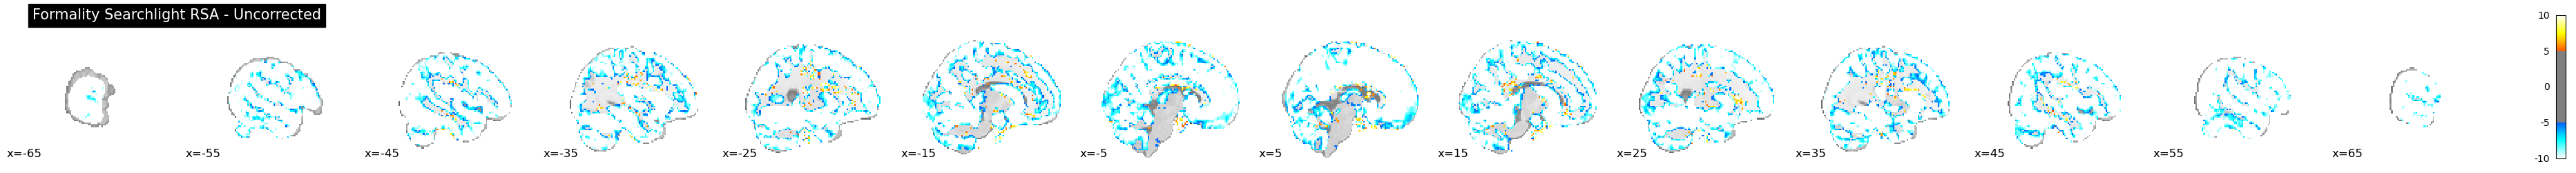

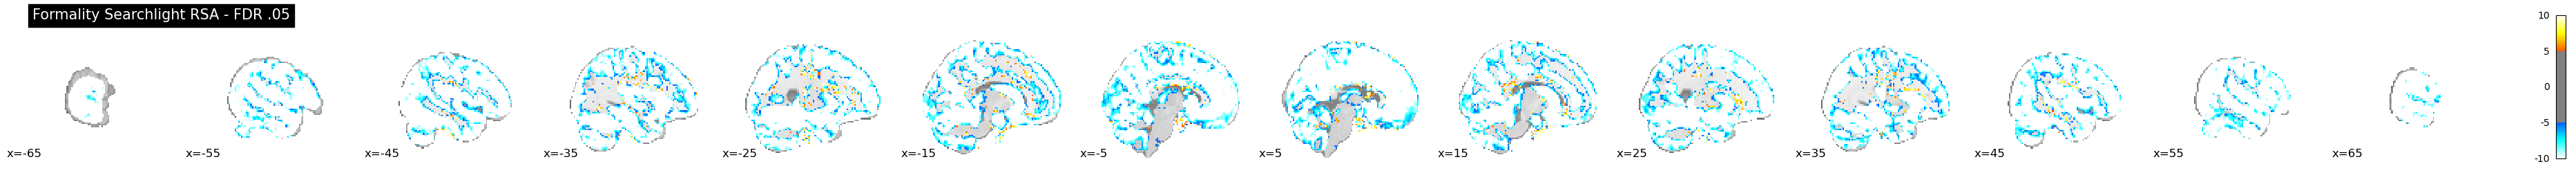

In [8]:
plot_stat_map(rdm_stats_all['college_mdoors_correct']['t'].to_nifti(), threshold=5,
    cut_coords=range(-65, 66, 10), display_mode='x', vmax=10, colorbar=True,
    title='Formality Searchlight RSA - Uncorrected')
#plt.savefig(data_dir+'/tmap_sl_comp1_unc.png')

plot_stat_map(rdm_stats_all['college_mdoors_correct']['thr_t'].to_nifti(), threshold=5,
    cut_coords=range(-65, 66, 10), display_mode='x', vmax=10, colorbar=True,
    title='Formality Searchlight RSA - FDR .05')
#plt.savefig(data_dir+'/tmap_sl_comp1_fdr05.png')